**Problema** : Riconoscere se il soggetto indossa una mascherina oppure non indossa nessuna protezione.

**Soluzone proposta**: Creo dizionario di visual word dalle immagini di training. Dalle immagini creo l'istogramma di visual word per ogni immagine e classifico tramite un classificatoe SVM.

La risoluzione con BoW passa per tre step principali:
* **Feature Extraction** :Determinare le mie feature che caratterizzano l'immagine.
* **Codebook Construction** : Creazione del dizionario attraverso un algorito di clustering(k-means).
* **Classification** Classificazione della immagini viste come un istogramma di patch creato dal mio dizionario allenato e classificate tramite svm(da sisitemare).


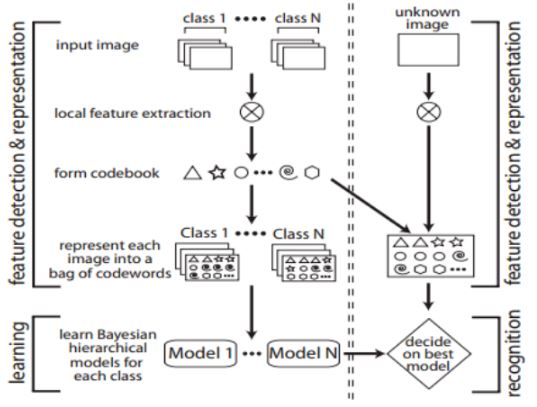

Importo le librerie che mi servono

In [1]:
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score,confusion_matrix
import cv2 as cv
import os
import matplotlib.pyplot as plt
import random
import pylab as pl

In [2]:
train_path="archive/Face Mask Dataset/Train"
class_names=os.listdir(train_path)

In [3]:
print(class_names)

['WithMask', 'WithoutMask']


Creo due contenitori per il percoso delle immagini e la loro classe

In [4]:
image_paths=[]
image_classes=[]

Creare lista per tutti i filename nella directory

In [5]:
def img_list(path):
    return (os.path.join(path,f) for f in os.listdir(path))

In [6]:
# ciclo for su ogni classe del training set
for training_name in class_names:
    #estraggo la directory delle classi
    dir_=os.path.join(train_path,training_name)
    class_path=img_list(dir_)#class 'generator', itero sulla classe 
    image_paths+=class_path #vado a creare una lista della posizione di ogni immagine
#in totale ho 10000 immagini di test, 5000 per ogni classe

In [7]:
image_classes_0=[0]*(len(image_paths)//2)# creo label per ogni classe

In [8]:
image_classes_1=[1]*(len(image_paths)//2)# creo label per ogni classe

In [9]:
image_classes=image_classes_0+image_classes_1
len(image_classes)

10000

ora ad ogni immagine assegno l'etichetta:
* zero = withmask
* uno = withoutmask

In [10]:
D=[]
#la struttura D contiene il path dell'immagine con la sua corrispettiva etichetta
for i in range(len(image_paths)):
    D.append((image_paths[i],image_classes[i]))
    
print(D[1][0])

archive/Face Mask Dataset/Train\WithMask\100.png


Visualizzo due esempio del mio dataset di training:

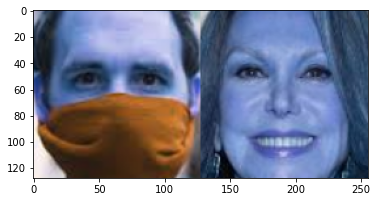

In [11]:
#visualizzo due esempi delle mie due classi 
import numpy as np
import matplotlib.pyplot as plt

img_A =  cv.imread(D[50][0])
img_B =  cv.imread(D[5000][0])

#per visualizzare le due immagini le ho inserite in un numpy array e poi ho plottato l'array
#metodo discutibile, magari da sistemare
dim=(128,128)
img_A_2= cv.resize(img_A,dim)
img_B_2= cv.resize(img_B,dim)
plot_image = np.concatenate((img_A_2, img_B_2), axis=1)

plt.imshow(plot_image)

**Estrazione delle feature con BOW** : creo feature SIFT.

<class 'cv2.xfeatures2d_SIFT'>


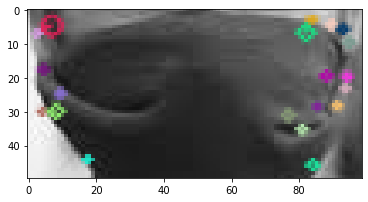

In [12]:


#calcolo che devo fare per ogni immagine e mi creo la mia lista di descrittori che sono le mie SIFT

#carico imamgine
img = cv.imread(D[50][0])
cut_image = img[img.shape[0]//2: img.shape[0], 0:img.shape[1]]


gray= cv.cvtColor(cut_image,cv.COLOR_BGR2GRAY)#la porto in scala di grigi
plt.imshow(gray)

sift = cv.xfeatures2d.SIFT_create() #creo oggetto sift
print(type(sift))

kp = sift.detect(gray,None) #trova i keypoint nell'immagine 
img_1=cv.drawKeypoints(gray,kp,cut_image,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) #disegno cerchi intorni ai miei keypoint
plt.imshow(img_1)

kp,des = sift.compute(gray,kp)#calcolo descitori, è un array di N(#keypoint)x128

In [13]:
print(des.shape) 

(21, 128)


Ora vado ad estrarmi i descrittori per ogni immagine del data_set

In [14]:
#oggetto sift già istanziato
tot_list=[]#lista descrittori con immagini associata
des_list=[] #lista per descrittori, la uso dopo
new_D=[]#nuovo dataset con classi e immagini non Null
p=0

from tqdm import tqdm #algoritmo intelligente che calcola tempo di esecuzione rimanente
from time import sleep
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)
#for i in tqdm(range(len(image_paths)), desc='Calcolo Keypoint e descrittori'):
for i in tqdm(range(len(image_paths)), desc='Calcolo Keypoint e descrittori'):
    
    im=cv.imread(D[i][0])
    cut_image = im[im.shape[0]//2: im.shape[0], 0:im.shape[1]]
    cut_image_gray= cv.cvtColor(cut_image,cv.COLOR_BGR2GRAY)#la porto in scala di grigi
    
    kp1, descriptor = sift.detectAndCompute(cut_image_gray,None)
        
    if descriptor is not None:
        #print('indice presente = ',i)
        p+=1
        new_D.append((D[i][0],D[i][1]))
        tot_list.append((D[i][0],descriptor))
        des_list.extend(descriptor) #extend a differenza di append aggiunge un singolo elemento alla volta alla lista
        # es: 'ciao' => 'c' 'i' 'a' 'o'
print('dal mio train set ho tenuto',p,' immagini')

Calcolo Keypoint e descrittori: 100%|██████████| 10000/10000 [00:48<00:00, 204.27it/s]

dal mio train set ho tenuto 9968  immagini


In [15]:

print(len(tot_list))
print(len(new_D))

10000
9968
9968


Aggiorno le label del mio train set

In [16]:

image_classes_0=[]
image_classes_1=[]

for i in range(len(new_D)):
    
    #D.append((image_paths[i],image_classes[i])
    if(new_D[i][1]==0):
        
        image_classes_0.append(0)# creo label per ogni classe
    else:
        image_classes_1.append(1)

        
image_classes=image_classes_0+image_classes_1



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172


3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180


In [17]:
#print(len(des_list))
#print(tot_list[1])
print(len(image_classes))

9968


Implemento algorimto K-means sui descrittori, creo dizionario BOW

Il MiniBarchKmeans è una variante dell'algorimto Kmeans, il quale usa dei mini-bathes per ridurre il tempo di computazione, pur cercando di ottimizzare la stessa funzione obbiettivo.

I mini-batches sono dei subset dell'intero data set, sono randomicamente campionati in ogni iterzione di training.
Questi mini-batch riducono drasticamente la quantità di calcolo necessaria per convergere a una soluzione locale. Però k-means che utilizza dei mini-batch produce dei risultati che sono generalmente di poco peggiori dell'algoritmo standard.

**funzionamento:**
L'algoritmo itera tra due passaggi principali, in modo simile al K-means standard:
* Nel primo passo: i campioni vengono estratti casualmente dal set di dati, per formare un mini-batch. Questi vengono quindi assegnati al centroide più vicino. 
* Nella seconda fase, i centroidi vengono aggiornati. A differenza di k-means, questo viene fatto su una base per campione. Per ogni campione nel mini-batch, il centroide assegnato viene aggiornato prendendo la media in streaming del campione e tutti i campioni precedenti assegnati a quel centroide. Questo ha l'effetto di diminuire la velocità di variazione di un centroide nel tempo. Questi passaggi vengono eseguiti fino al raggiungimento della convergenza o di un numero predeterminato di iterazioni.

MiniBatchKMeans converge più velocemente di KMeans, ma la qualità dei risultati è ridotta. In pratica questa differenza di qualità può essere piuttosto piccola. [Fonte](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html)

"Building visual dictionary using cv2.BOWKMeansTrainer is super slow when using > 100 clusters. While using sklearn.cluster.KMeans solves the speed issue, it requires huge amount of memory (8 GB of RAM is still insufficient to handle > 400 clusters). That’s where klearn.cluster.MiniBatchKMeans comes into picture." [Fonte](https://yohanes.gultom.id/2018/05/20/sift-surf-bow-for-big-number-of-clusters/)

In [18]:
''' 
from sklearn.cluster import MiniBatchKMeans

#decido quanti cluster creare e quindi quanto grande sarà il mio dizionario, attenzione a sparsità
dictionary_size=200
print('Creo dizionario BoW usando l\'algoritmo di clustering K-Means con k={}.'.format(dictionary_size))
dictionary = MiniBatchKMeans(n_clusters=dictionary_size, batch_size=100, verbose=0)

n_cluster= numero di cluster che creo, ovvero il numero di centroidi che genera
batch_size= dimnsione del mio mini-batch
verbose= attivata per visualizzare maggiore informazioni
The number of clusters to form as well as the number of centroids to generate.
‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. 


dictionary.fit(np.array(des_list))#calcola i centroidi dei miei descrittori suddividendoli in mini-batch
'''

" \nfrom sklearn.cluster import MiniBatchKMeans\n\n#decido quanti cluster creare e quindi quanto grande sarà il mio dizionario, attenzione a sparsità\ndictionary_size=200\nprint('Creo dizionario BoW usando l'algoritmo di clustering K-Means con k={}.'.format(dictionary_size))\ndictionary = MiniBatchKMeans(n_clusters=dictionary_size, batch_size=100, verbose=0)\n\nn_cluster= numero di cluster che creo, ovvero il numero di centroidi che genera\nbatch_size= dimnsione del mio mini-batch\nverbose= attivata per visualizzare maggiore informazioni\nThe number of clusters to form as well as the number of centroids to generate.\n‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. \n\n\ndictionary.fit(np.array(des_list))#calcola i centroidi dei miei descrittori suddividendoli in mini-batch\n"

In [19]:
from scipy.cluster.vq import kmeans,vq

k=20
voc,variance=kmeans(np.array(des_list),k,1)

In [20]:
print(voc[1].shape)

(128,)


In [21]:
''' 
from sklearn.metrics.pairwise import pairwise_distances_argmin
mbk_means_cluster_centers = np.sort(dictionary.cluster_centers_, axis = 0)
mbk_means_labels = pairwise_distances_argmin(np.array(des_list), mbk_means_cluster_centers)
  
# print the labels of each data
'''


' \nfrom sklearn.metrics.pairwise import pairwise_distances_argmin\nmbk_means_cluster_centers = np.sort(dictionary.cluster_centers_, axis = 0)\nmbk_means_labels = pairwise_distances_argmin(np.array(des_list), mbk_means_cluster_centers)\n  \n# print the labels of each data\n'

In [22]:
#print(type(dictionary))

In [23]:
print(type(voc))

<class 'numpy.ndarray'>


**creo istogramma delle immagini:**
* 1): mi creo una matrice 10000(#samples)x #_cluster
* 2): per ogni immagine del mio train set vado a prendermi i descrittori di quella immagine.
* 3): Grazie alla funzione vq che prende in input i descrittori dell'immagine e del vocabolario riesco a calcolarmi le visual word presenti nella mia immagine 
* 4): vado ad iterare sulle visual word trovate e assegno +1 per ogni visual che ha la mia immagine

In [24]:
print(len(new_D))
print(len(tot_list))

9968
9968


In [25]:
im_features=np.zeros((len(new_D),k),"float32")#matrice 10000 x #_cluster, numero immagini di test per bins

for i in range(len(new_D)):#per ogni immagine creo struttura con quante visual word contiene 
    
    #print(tot_list[i][1])
    words,distance=vq(tot_list[i][1],voc)
    #ritorna words = Un array di lunghezza M(patch trovate nell'immagine) che contiene l'indice della parola nel dizionario dei codici per ogni osservazione. 
    #riotna distance tra l'osservazione e la piu vicina visual
    #print(words)
    #print(distance)
    for w in words:
        im_features[i][w]+=1#inizialmnete il mio istogramma è tutto a zero[0 0 ... 0 0 0]
        #poi man mano aggiungo le visual word trovate per quell'immagine


**Applico standardizzazione dei dati:** faccio scalatura dei dati per questioni di ottimizzazione, infatti è meglio tenre numeri bassi e intorno allo zero. Ci sono tanti tipi di normalizzazione, in questo caso uso la Z-norm.

In [26]:
from sklearn.preprocessing import StandardScaler

stdslr=StandardScaler().fit(im_features)# Compute the mean and std to be used for later scaling.
im_features=stdslr.transform(im_features)# Perform standardization by centering and scaling, z = (x - u) / std


**Classificazione degli istogrammi con SVM**
* 1)kernel lineare
* 2)Kernel RBF

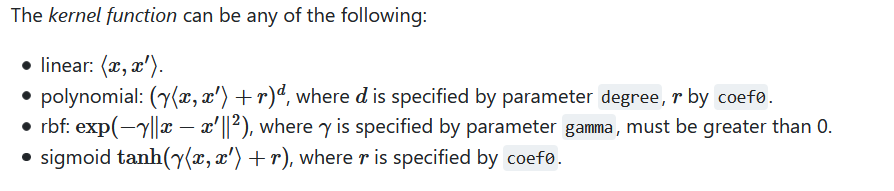

In [27]:
print(len(im_features))


9968


In [28]:
from sklearn.svm import LinearSVC

SVM_Linear=LinearSVC(max_iter=80000, verbose=1)# C=1
SVM_Linear.fit(im_features,np.array(image_classes))

[LibLinear]

LinearSVC(max_iter=80000, verbose=1)

In [66]:
# Train a SVM classification model
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], } #griglia dei parametri C(peso alla mie slack varible)
#C influenza la mia phi(w) aggiungendo un costo, infatti per massimizzare il margine devo minimizzare la phi(w)
#gamma è la deviazione standard del mio kernel gaussiano
param_grid_1 = {'C': [1e3],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
SVM_RBF = GridSearchCV(SVC(kernel='rbf'), param_grid_1)#dovrebbe ricercare il miglio classificatore con la griglia dei parametri
SVM_RBF = SVM_RBF.fit(im_features,np.array(image_classes))



In [67]:
print('Miglior paramteri trovati:', SVM_RBF.best_params_)


Miglior paramteri trovati: {'C': 1000.0, 'gamma': 0.005}


In [61]:
# Train a SVM classification model
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid_poly = {'degree': [2,3,4],
              'coef0': [0.0, 1.0], } #griglia dei parametri 

SVM_poly = GridSearchCV(SVC(kernel='poly'), param_grid_poly)#ricerco il miglio classificatore con la griglia dei parametri
SVM_poly = SVM_poly.fit(im_features,np.array(image_classes))

In [62]:
print('Miglior paramteri trovati:', SVM_poly.best_params_)

Miglior paramteri trovati: {'coef0': 1.0, 'degree': 4}


**Test del Classificatore**
* 1) Prendo immagini di test e ne calcolo i descrittori SIFT
* 2) Creo l'istogramma con il vocabolario allenato in precedenza
* 3) Classifico con SVM appena allenata

In [29]:
des_list_test=[] #creo lista di descrittori per le miei immagini di test 

In [30]:
#creo set di test
test_path="archive/Face Mask Dataset/Test"
class_names_test=os.listdir(test_path)

print(class_names_test)
image_paths_test=[]
image_classes_test=[]

def img_list_test(path):#itero sulla classe
    return (os.path.join(path,f) for f in os.listdir(path))

for test_name in class_names_test: #itero sulle mie due classi in gioco
    dir_=os.path.join(test_path,test_name)#directori dove di trova le immagini
    class_path_test=img_list_test(dir_)
    image_paths_test+=class_path_test#vado a creare una lista della posizione di ogni immagine
    
#NB 483 immagini withMask e 509 without mask 

['WithMask', 'WithoutMask']


In [31]:
#creo test set
len(image_paths_test)
Test_D=[]
for i in range(len(image_paths_test)):
    if (i<483):
        Test_D.append((image_paths_test[i],0))
    else:
        Test_D.append((image_paths_test[i],1)) 

        
#Nb: 0=withMask, 1=withoutMask

In [49]:
#test del test_D, usato per vedere se avevo classificato correttamente       
''' img_A_test =  cv.imread(Test_D[800][0])
print(Test_D[481])
plt.imshow(img_A_test)'''

' img_A_test =  cv.imread(Test_D[800][0])\nprint(Test_D[481])\nplt.imshow(img_A_test)'

In [33]:

for image_pat_test in image_paths_test:
    image=cv.imread(image_pat_test)
    cut_image = image[image.shape[0]//2: image.shape[0], 0:image.shape[1]]
    cut_image_gray= cv.cvtColor(image,cv.COLOR_BGR2GRAY)
    kp=sift.detect(cut_image_gray,None)#trovo keypoint
    keypoints_test,descriptor_test= sift.compute(cut_image_gray, kp)#calcolo descrittori keypoint
    if descriptor_test is None: #nella maggior parte delle prove non ho riscontarato descrittori nulli
        print('trovato des null')
    des_list_test.append((image_pat_test,descriptor_test))

Creo il mio istogramma di testing

In [34]:
test_features=np.zeros((len(image_paths_test),k),"float32")#matrice dove raccolgo le feture
for i in range(len(image_paths_test)):
    words,distance=vq(des_list_test[i][1],voc)#controllo le parole trovate in base a quanto distanti sono dai miei cluster
    for w in words:
        test_features[i][w]+=1

In [48]:
#stampo istogrammi, vedo già che ci sono delle differenze tra istogrammi di diverse classi  
''' print(test_features[400])
print(test_features[401])
print(test_features[800])
print(test_features[801])'''

' print(test_features[400])\nprint(test_features[401])\nprint(test_features[800])\nprint(test_features[801])'

In [36]:
#normalizzo le feature
stdslr=StandardScaler().fit(test_features)
test_features_norm=stdslr.transform(test_features)

In [51]:
#mi faccio un'idea delle mie feature normalizzate
'''print(test_features_norm[400])
print(test_features_norm[401])
print(test_features_norm[800])
print(test_features_norm[801])'''

[-0.05853058 -0.35131574 -0.36463997  0.02725453  0.03611153 -0.3286566
 -0.75920165  0.90121454  0.549605   -0.31782633 -0.40315774 -0.20423868
 -0.17074578  1.3298861  -0.5357583  -0.67744744 -0.60329247 -0.35711423
  0.4651456  -0.48807   ]
[-0.59243715 -0.5333979  -0.24222954  0.02725453  0.891067   -0.05479911
 -0.75920165 -0.06170803  1.2300217  -0.5054394   0.14908265 -0.47914338
  0.09124929  1.3298861  -0.11451215 -0.3848161  -0.12039887 -0.16757046
 -0.176613   -0.3636059 ]
[-0.59243715 -0.5333979  -0.4870504  -0.28350973 -0.5623573  -0.60251415
  0.12386305 -0.8870703  -0.61682355 -0.13021329 -0.40315774 -0.20423868
 -0.56373835 -0.57282025 -0.5357583  -0.8237631  -0.60329247 -0.73620176
 -0.176613   -0.6125341 ]
[-0.4589605  -0.5333979  -0.6094609  -0.59427404 -0.47686175  0.21905841
 -0.63304955 -0.47438914 -0.22801405 -0.5054394  -0.40315774 -0.47914338
 -0.17074578 -1.0205159  -0.39534292 -0.8237631   0.04056566 -0.92574555
 -0.6579319  -0.48807   ]


In [38]:
#calcolo le classi vere
true_classes=[]
for i in Test_D:
    if i[1]==0:
        true_classes.append("WithMask")
    else:
        true_classes.append("WithoutMask")

In [39]:
#print(true_classes)

In [40]:
#predico le classi dal mio svm lineare 
predict_classes=[]
for i in SVM_Linear.predict(test_features_norm):
    if i==1:
        predict_classes.append("WithoutMask")
    else:
        predict_classes.append("WithMask")

In [68]:
#predico le classi dal mio svm gaussiano
predict_classes_RBF=[]
for i in SVM_RBF.predict(test_features_norm):
    if i==1:
        predict_classes_RBF.append("WithoutMask")
    else:
        predict_classes_RBF.append("WithMask")

In [63]:
#predico le classi dal mio svm gaussiano
predict_classes_poly=[]
for i in SVM_poly.predict(test_features_norm):
    if i==1:
        predict_classes_poly.append("WithoutMask")
    else:
        predict_classes_poly.append("WithMask")

In [46]:
#calcolo accuratezza del mio classificatore
accuracy=accuracy_score(true_classes,predict_classes)
print('accuratezza classificatore lineare= ',"{:.2f}".format(accuracy*100),'%')

accuratezza classificatore=  86.79 %


In [82]:
# Train a SVM classification model, tempo di esecuzione del codice circa 12 minuti
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
Costo=[1e3, 5e3, 1e4, 5e4, 1e5]
GAMMA=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
max=0.0
gamma_top=0.0
c_top=0.0
for c in tqdm(Costo):
    
    for gamma in GAMMA:
        
        SVM_RBF=SVC(kernel='rbf',gamma=gamma,C=c)
        SVM_RBF = SVM_RBF.fit(im_features,np.array(image_classes))
        
        #predico le classi dal mio svm gaussiano
        predict_classes_RBF=[]
        for i in SVM_RBF.predict(test_features_norm):
            if i==1:
                predict_classes_RBF.append("WithoutMask")
            else:
                predict_classes_RBF.append("WithMask")
        #calcolo accuratezza del mio classificatore
        accuracy=accuracy_score(true_classes,predict_classes_RBF)
        
        #calcolo massima accuratezza
        if(accuracy > max):
            max=accuracy
            gamma_top=gamma
            c_top=c
print('massima accuratezza classificatore RBF= ',"{:.2f}".format(max*100),'%', ' gamma=',gamma_top, ' C=', c_top)            


100%|██████████| 5/5 [12:19<00:00, 147.99s/it]

massima accuratezza classificatore RBF=  88.71 %  gamma= 0.0001  C= 5000.0


In [84]:
# Train a SVM classification model
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
Degree=[2,3,4.5]
coeff0=[0.0, 1.0]
max=0.0
coeff_top=0.0
degree_top=0.0
for d in tqdm(Degree):
    
    for coeff in coeff0:
        
        SVM_poly=SVC(kernel='poly',degree=d,coef0=coeff)
        SVM_poly = SVM_poly.fit(im_features,np.array(image_classes))
        
        #predico le classi dal mio svm gaussiano
        predict_classes_poly=[]
        for i in SVM_poly.predict(test_features_norm):
            if i==1:
                predict_classes_poly.append("WithoutMask")
            else:
                predict_classes_poly.append("WithMask")
        #calcolo accuratezza del mio classificatore
        accuracy=accuracy_score(true_classes,predict_classes_poly)
        
        
        if(accuracy > max):
            max=accuracy
            degreee_top=d
            coeff_top=coeff
            
print('massima accuratezza classificatore poly= ',"{:.2f}".format(max*100),'%', ' degreee=',degreee_top, ' coeff=', coeff_top) 

100%|██████████| 3/3 [00:09<00:00,  3.30s/it]

massima accuratezza classificatore poly=  86.59 %  degreee= 2  coeff= 1.0
